Goal: Develop and demo process to derive labeled `speaking` region from audio amplitude measures

In [1]:
import ecog_speech
from ecog_speech import datasets, experiments
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()
%matplotlib inline

### Select dataset and load
- Data proceesed into pandas dataframes with load_data()

In [2]:
ptuples_l = ecog_speech.datasets.NorthwesternWords.make_tuples_from_sets_str(sets_str='MC-22-1')

t_data_map = datasets.NorthwesternWords.load_data(*ptuples_l[0])

2022-03-05 17:35:56,639 - ecog_speech.datasets.NorthwesternWords.load_data - INFO - ---22-1-2-MayoClinic---
2022-03-05 17:35:56,640 - ecog_speech.datasets.NorthwesternWords.load_data - INFO - |--->Using Subset: None
2022-03-05 17:35:56,641 - ecog_speech.datasets.NorthwesternWords.load_data - DEBUG - Path : /home/morgan/Projects/CMSCResearch/ECOGSpeech/ecog_speech/../data/SingleWord/MayoClinic/Data/MC022-SW-S1-R2.mat
2022-03-05 17:36:01,809 - ecog_speech.datasets.NorthwesternWords.load_data - DEBUG - Matlab keys : ['__header__', '__version__', '__globals__', 'ECOG_signal', 'audio', 'fs_audio', 'fs_signal', 'stimcode', 'wordcode', 'electrodes']


In [3]:
t_data_map.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ECOG_signal', 'audio', 'fs_audio', 'fs_signal', 'stimcode', 'wordcode', 'electrodes'])

In [4]:
isinstance(t_data_map['fs_audio'], np.ndarray)

True

In [5]:
t_data_map['fs_audio'].reshape(-1)

array([47780], dtype=uint16)

### Define the preprocessing pipelines to eaxmine
- General steps
    - Produce new 'stim' signal from the audio signal (the PowerThreshold step)
    - Use the new stim to derive label regions based on offsets from the onset of the stim (like has been done previously)

In [4]:
# Map an arbitrary name of a processing pipeline to a pipeline
pipeline_map = dict(
    stim_based_orig          = (ecog_speech.feature_processing.SubsampleECOG()
                                 >> ecog_speech.feature_processing.ChangSampleIndicesFromStim()),
    
    audio_thresh_w2          = (ecog_speech.feature_processing.SubsampleECOG() 
                                 >> ecog_speech.feature_processing.PowerThreshold(window_samples=48000//2)
                                 >> ecog_speech.feature_processing.ChangSampleIndicesFromStim(stim_speaking_offset=pd.Timedelta(0, 's'),
                                                                                              stim_silence_offset=pd.Timedelta(1.5, 's'))),
    audio_thresh_w4          = (ecog_speech.feature_processing.SubsampleECOG() 
                                 >> ecog_speech.feature_processing.PowerThreshold(window_samples=48000//4)
                                 >> ecog_speech.feature_processing.ChangSampleIndicesFromStim(stim_speaking_offset=pd.Timedelta(0, 's'),
                                                                                              stim_silence_offset=pd.Timedelta(1.5, 's'))),
    audio_thresh_w4_p25shift = (ecog_speech.feature_processing.SubsampleECOG() 
                                 >> ecog_speech.feature_processing.PowerThreshold(window_samples=48000//4)
                                 >> ecog_speech.feature_processing.ChangSampleIndicesFromStim(stim_speaking_offset=pd.Timedelta(-.25, 's'),
                                                                                              stim_silence_offset=pd.Timedelta(1.5, 's'))), 
                    )

### Run Pipelines

In [5]:
from copy import deepcopy
p_output_map = {k: p(deepcopy(t_data_map)) for k, p in tqdm(pipeline_map.items())}

  0%|          | 0/4 [00:00<?, ?it/s]

--
remap: ecog <- ecog_subs
remap: fs_signal <- fs_signal_subs
remap: stim <- stim_subs
remap: stim_diff <- stim_diff_subs
(600, Timedelta('0 days 00:00:00.500000'))
Max window size: 300
--
remap: ecog <- ecog_subs
remap: fs_signal <- fs_signal_subs
remap: stim <- stim_subs
remap: stim_diff <- stim_diff_subs
stim_s and stim_auto not equal: 116 - 1 != 113
--
remap: stim <- stim_pwrt
remap: stim_diff <- stim_pwrt_diff
(600, Timedelta('0 days 00:00:00.500000'))
Max window size: 300
--
remap: ecog <- ecog_subs
remap: fs_signal <- fs_signal_subs
remap: stim <- stim_subs
remap: stim_diff <- stim_diff_subs
stim_s and stim_auto not equal: 116 - 1 != 113
--
remap: stim <- stim_pwrt
remap: stim_diff <- stim_pwrt_diff
(600, Timedelta('0 days 00:00:00.500000'))
Max window size: 300
--
remap: ecog <- ecog_subs
remap: fs_signal <- fs_signal_subs
remap: stim <- stim_subs
remap: stim_diff <- stim_diff_subs
stim_s and stim_auto not equal: 116 - 1 != 113
--
remap: stim <- stim_pwrt
remap: stim_diff <- s

### Plot labeling results of pipelines

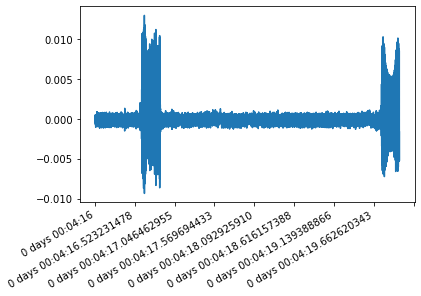

In [20]:
ax = p_output_map['audio_thresh_w4_p25shift']['audio'].loc['4m16s': '4m19s'].plot()
ax.get_figure().set_facecolor("white")

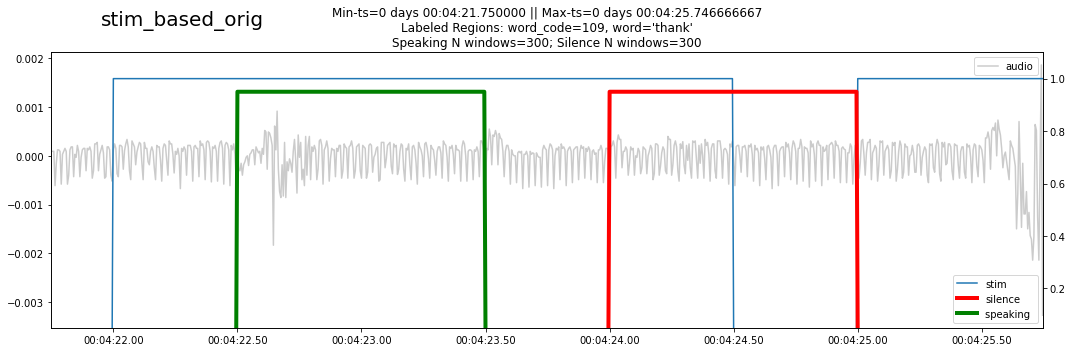

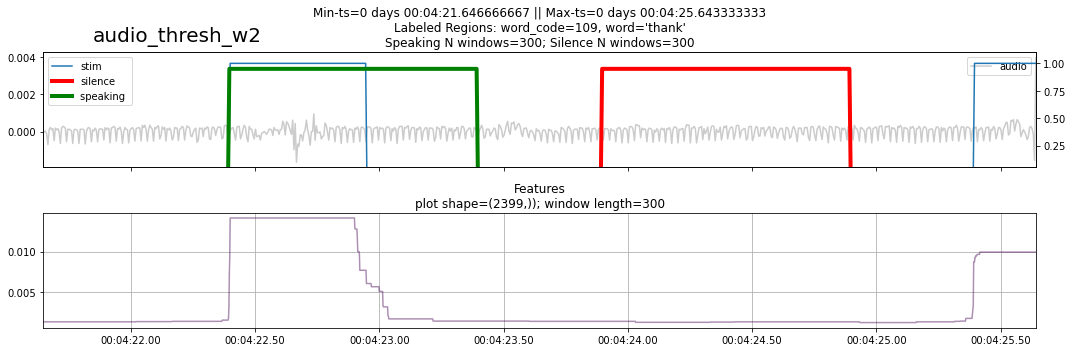

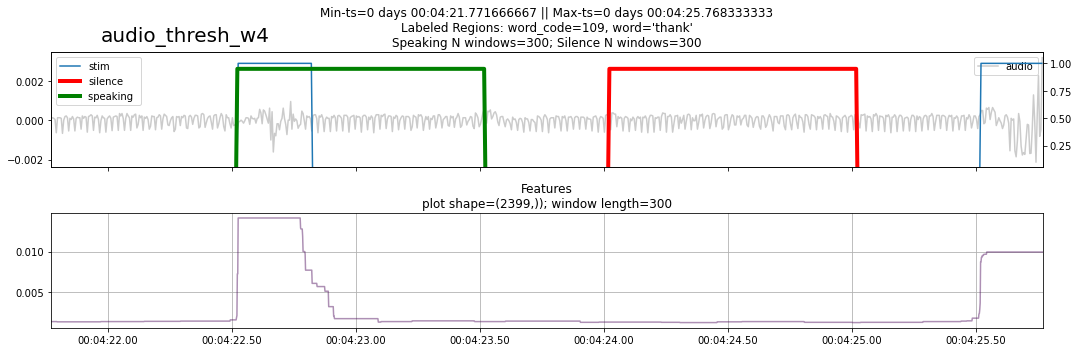

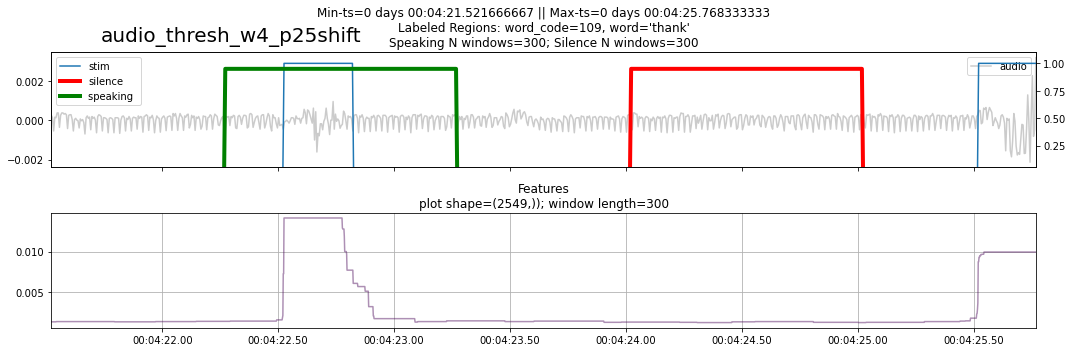

In [8]:
import matplotlib

word_code = np.random.choice(list(t_data_map['word_code_d'].keys()))

fkey = 'rolling_audio_pwr'
for i, (k, p_o_map) in enumerate(p_output_map.items()):
    fig, ax = datasets.NorthwesternWords.plot_word_sample_region(p_o_map, word_code=word_code,
                                                                 subplot_kwargs=dict(sharex='col'),
                                                                 feature_key=fkey, plot_features=fkey in p_o_map,
                                                                 #ax=axs[i*2],
                                                                 #feature_ax=axs[(i*2) + 1] if fkey in p_o_map else None
                                                                )
    ax.annotate(k, (0.05, 1.1), xycoords='axes fraction', fontsize=20)
    fig.set_facecolor("white")
fig.tight_layout()